# Bayesian Inference 2: Project Report

### Title: "Missing orthodox population in the Vyborg poll tax register 1906-1917"

### Name: Antti Härkönen


## Abstract

> A graphical Bayesian regression model with binary latent variable to indicate missing component of the population is
> used to analyse a time series covering the Russian orthodox population of Vyborg in 1905-1917.
> The results indicate that the orthodox population included in the poll tax register of Vyborg grew by 5 per cent
> per annum during the period, while the whole orthodox parish, including the suburbs, grew by 2.3 per cent per annum.

## Introduction

This project deals with the size of ethnic groups in the city of Vyborg between 1906 and 1917. At the time the city was
a part of Autonomous Grand Duchy of Finland, which was a part of the Russian Empire. The city had unusually diverse, but
mostly Lutheran, population. The members of the sizable Russian minority were mainly members Russian Orthodox church and
had a distinct identity, but little is known about how well they were integrated with the other population groups.
However, since the number of orthodox in poll tax records fluctuates wildly in several years, it is necessary to assess the
real size of the population using time series.

The aim of this project is to learn about the graphical models that could be used for studying challenging statistical
inference problems, where there are multiple sources of uncertainty.
My aim is to see whether a simple linear regression model combined with a latent binary variable for "missingness"
will yield useful results and to determine the real growth rate in the orthodox population.

Python libraries used in this project are the following:
* pymc3 for specifying Bayesian models
* arviz for visualising results of Bayesian computations
* pandas and numpy for managing data
* matplotlib for plotting
* daft for DAGs

Bayesian graphical models have rarely been used in historical demographic research, even though it is potentially very useful.
The most relevant publication has been [Voutilainen et al. 2020](http://urn.fi/URN:NBN:fi:jyu-202006174250). In this article
the authors use a graphical model to control the effects of a variety of different problems with the source material.
They create a novel reconstruction of Finnish population in the Early Modern period, and importantly, the Bayesian methods
allow the estimation of different uncertainties in the estimations, which is completely novel in Finnish historiography.
The proper specification of priors is very important in these cases, since the data has a lot of uncertain parts.

## Methods

### Dataset description and processing

The data is collected from following sources:
* Religious affiliation of inhabitants of each household is registered in the poll tax record of Vyborg.
* For most years, the number of Vyborgians living in other parts of Russian empire (mainly St. Petersburg) was also
recorded in poll tax record.
* Vyborg public health council (*Viipurin terveyshoitolautakunta*) published yearly statistics dealing with health and mortality.
These include data from parishes of Vyborg, such as population by parish. These statistics are available from 1906 onwards.

These sources are manually digitized from the digital copies of the archives and stored in csv files. Data files are read
and processed using the pandas module.

The number of orthodox people can be used as a proxy for ethnically Russian population, since well over 90 percent of Orthodox civilian
population of Vyborg were Russians. The population numbers are treated as continuous variables.

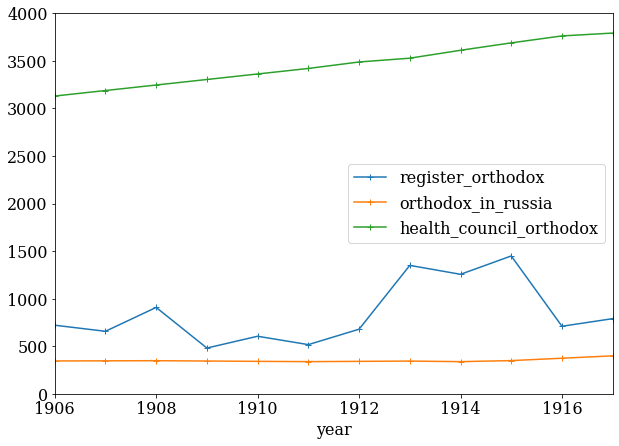

In [13]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('./data')
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
remove = poll_tax.in_russia_orthodox.copy()
remove.loc['1906':] = 0
poll_tax['orthodox'] = poll_tax.orthodox - remove
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
data = pd.DataFrame([
    poll_tax.orthodox,
    poll_tax.in_russia_orthodox,
    health_council,
]).T
data.columns = [
    'register_orthodox',
    'orthodox_in_russia',
    'health_council_orthodox',
]
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=True, figsize=(10, 7), xlim=(1906, 1917), ylim=(0, 4_000))
plt.show()

### Model description

Basic linear regression was chosen because of its simplicity. While demographic time series are rarely linear, the
period considered in this model is so short, linear model approximates real changes suitably well.

Because the data is small, priors have to be very informative. First, a basic regression model is used to determine the
parameters for the whole orthodox civilian parish of Vyborg based on the health council numbers. Then, the results from
these are used as priors for paramters describing the smaller orthodox population that have been recorded within the city.
In some years, the number of orthodox Vyborgians living in St. Petersburg is counted and added to the number of the orthodox
in the summary table of  the poll tax register, in some years not.
This is modelled by adding a binary latent variable $ z $, which equals 1 when the non-resident people are counted in
the totals.

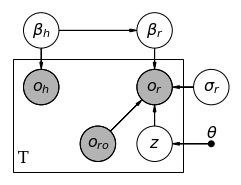

In [10]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('health_orthodox', r'$o_{h}$', 1, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_orthodox', r'$o_{r}$', 3, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('russia_orthodox', r'$o_{ro}$', 2, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('beta_orthodox_health', r'$\beta_h$', 1, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_register', r'$\beta_r$', 3, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('theta', r'$\theta$', 4, 1, fixed=True, scale=scale, observed=False)
pgm.add_node('z', r'$z$', 3, 1, fixed=False, scale=scale, observed=False)
pgm.add_node('sigma_register', r'$\sigma_r$', 4, 2, fixed=False, scale=scale, observed=False)

pgm.add_edge('russia_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('z', 'register_orthodox', directed=True)
pgm.add_edge('beta_orthodox_health', 'health_orthodox', directed=True)
pgm.add_edge('beta_orthodox_health', 'beta_orthodox_register', directed=True)
pgm.add_edge('beta_orthodox_register', 'register_orthodox', directed=True)
pgm.add_edge('sigma_register', 'register_orthodox', directed=True)
pgm.add_edge('theta', 'z', directed=True)

pgm.add_plate([0.5, 0.5, 3, 2], 'T')

pgm.render()

The inference model:

$ o_r = N(\mu_{o_h}, \sigma_{o_h}^2) $

$ \mu_{o_h} = \beta_0 + \beta_1 t - o_{ro} z $

$ \sigma_{o_h} \sim Exp(10) $

$ \theta = \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix}' $

$ z \sim Bernoulli(\theta) $

$ \beta_h \sim N\begin{pmatrix}\begin{bmatrix} 0.2 \\ 0.005 \end{bmatrix},
 \begin{bmatrix} 0.01 && 0 \\ 0 && 0.001 \end{bmatrix}\end{pmatrix} $

$ \beta_r \sim N\begin{pmatrix}\begin{bmatrix} 0.21 \times 0.3 \\ 0.004 \end{bmatrix},
 \begin{bmatrix} 0.005 && 0 \\ 0 && 0.001 \end{bmatrix}\end{pmatrix} $

Joint probability of the model:
$ P(\beta_h, \beta_r, o_h, o_{ro}, o_r, \sigma_r, z, \theta) =
 P(\beta_h)P(o_h \mid \beta_h)P(\beta_r \mid \beta_h)P(o_{ro})P(\theta)P(z \mid \theta)P(\sigma_r)P(o_r \mid o_{ro}, \beta_r, \sigma_r, z) $


### Inference Method

Hamiltonian Monte Carlo simulation is used to infer latent variables. The model is built using Python statistical inference library
[PyMC3](https://docs.pymc.io/) which implements No U-Turn Sampler (NUTS), which is a gradient-based Monte Carlo method. Since $\bf z$
is a binary variable, it has to be estimated using the Binary Gibbs-Metropolis sampling step.


## Experiment & Results


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 28100
Interrupted at 28,099 [14%]: Average Loss = 1.6406e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_health_1, beta_health_0]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6696395188214478, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_health_1, beta_health_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

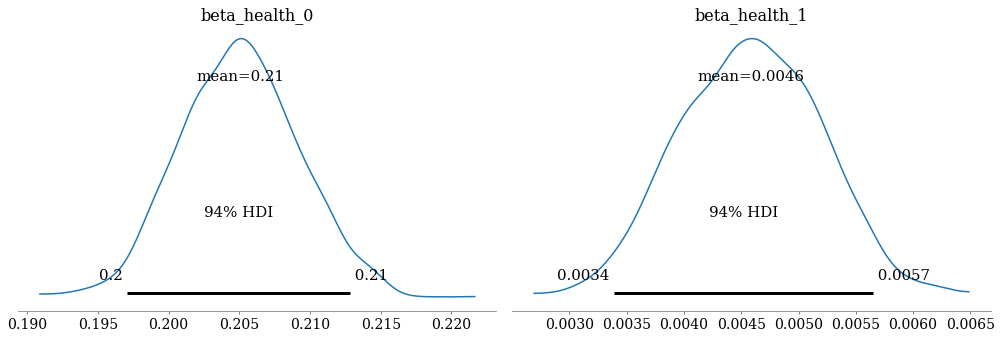

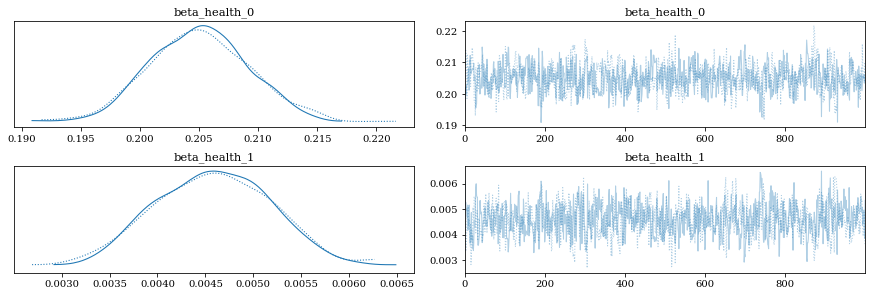

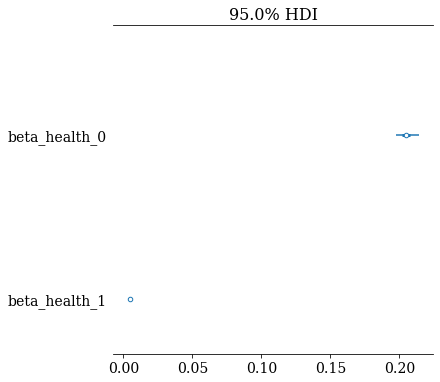

In [11]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

data_pm = data.iloc[26:-3,]
standard = 15_000
data_pm = data_pm / standard
start = 1906
data_pm['t'] = data_pm.index - start

with pm.Model() as model_health_council_orthodox:
    n, _ = data_pm.shape
    t = np.asarray(data_pm.t)
    beta_health_0 = pm.Normal(
        "beta_health_0",
        mu=0.2,
        sigma=0.01,
    )
    beta_health_1 = pm.Normal(
        "beta_health_1",
        mu=0.005,
        sigma=0.001,
    )
    # mu_health = tt.add(beta_health_0, tt.mul(beta_health_1, data_pm.t))
    mu_health = beta_health_0 + t * beta_health_1
    # sigma_total = pm.Exponential('sigma_total', 100)
    health_council = pm.Normal(
        'health_council',
        mu=mu_health,
        sigma=0.01,
        observed=np.asarray(data_pm.health_council_orthodox),
    )

    trace_health = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior_health = pm.sample_prior_predictive()
    posterior_health = pm.sample()
    posterior_pred_health = pm.sample_posterior_predictive(posterior_health)

az.plot_posterior(posterior_health)
az.plot_trace(posterior_health)
az.plot_forest(posterior_health, combined=True, hdi_prob=0.95)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_orthodox, beta_orthodox_1, beta_orthodox_0]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_orthodox, beta_orthodox_1, beta_orthodox_0]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

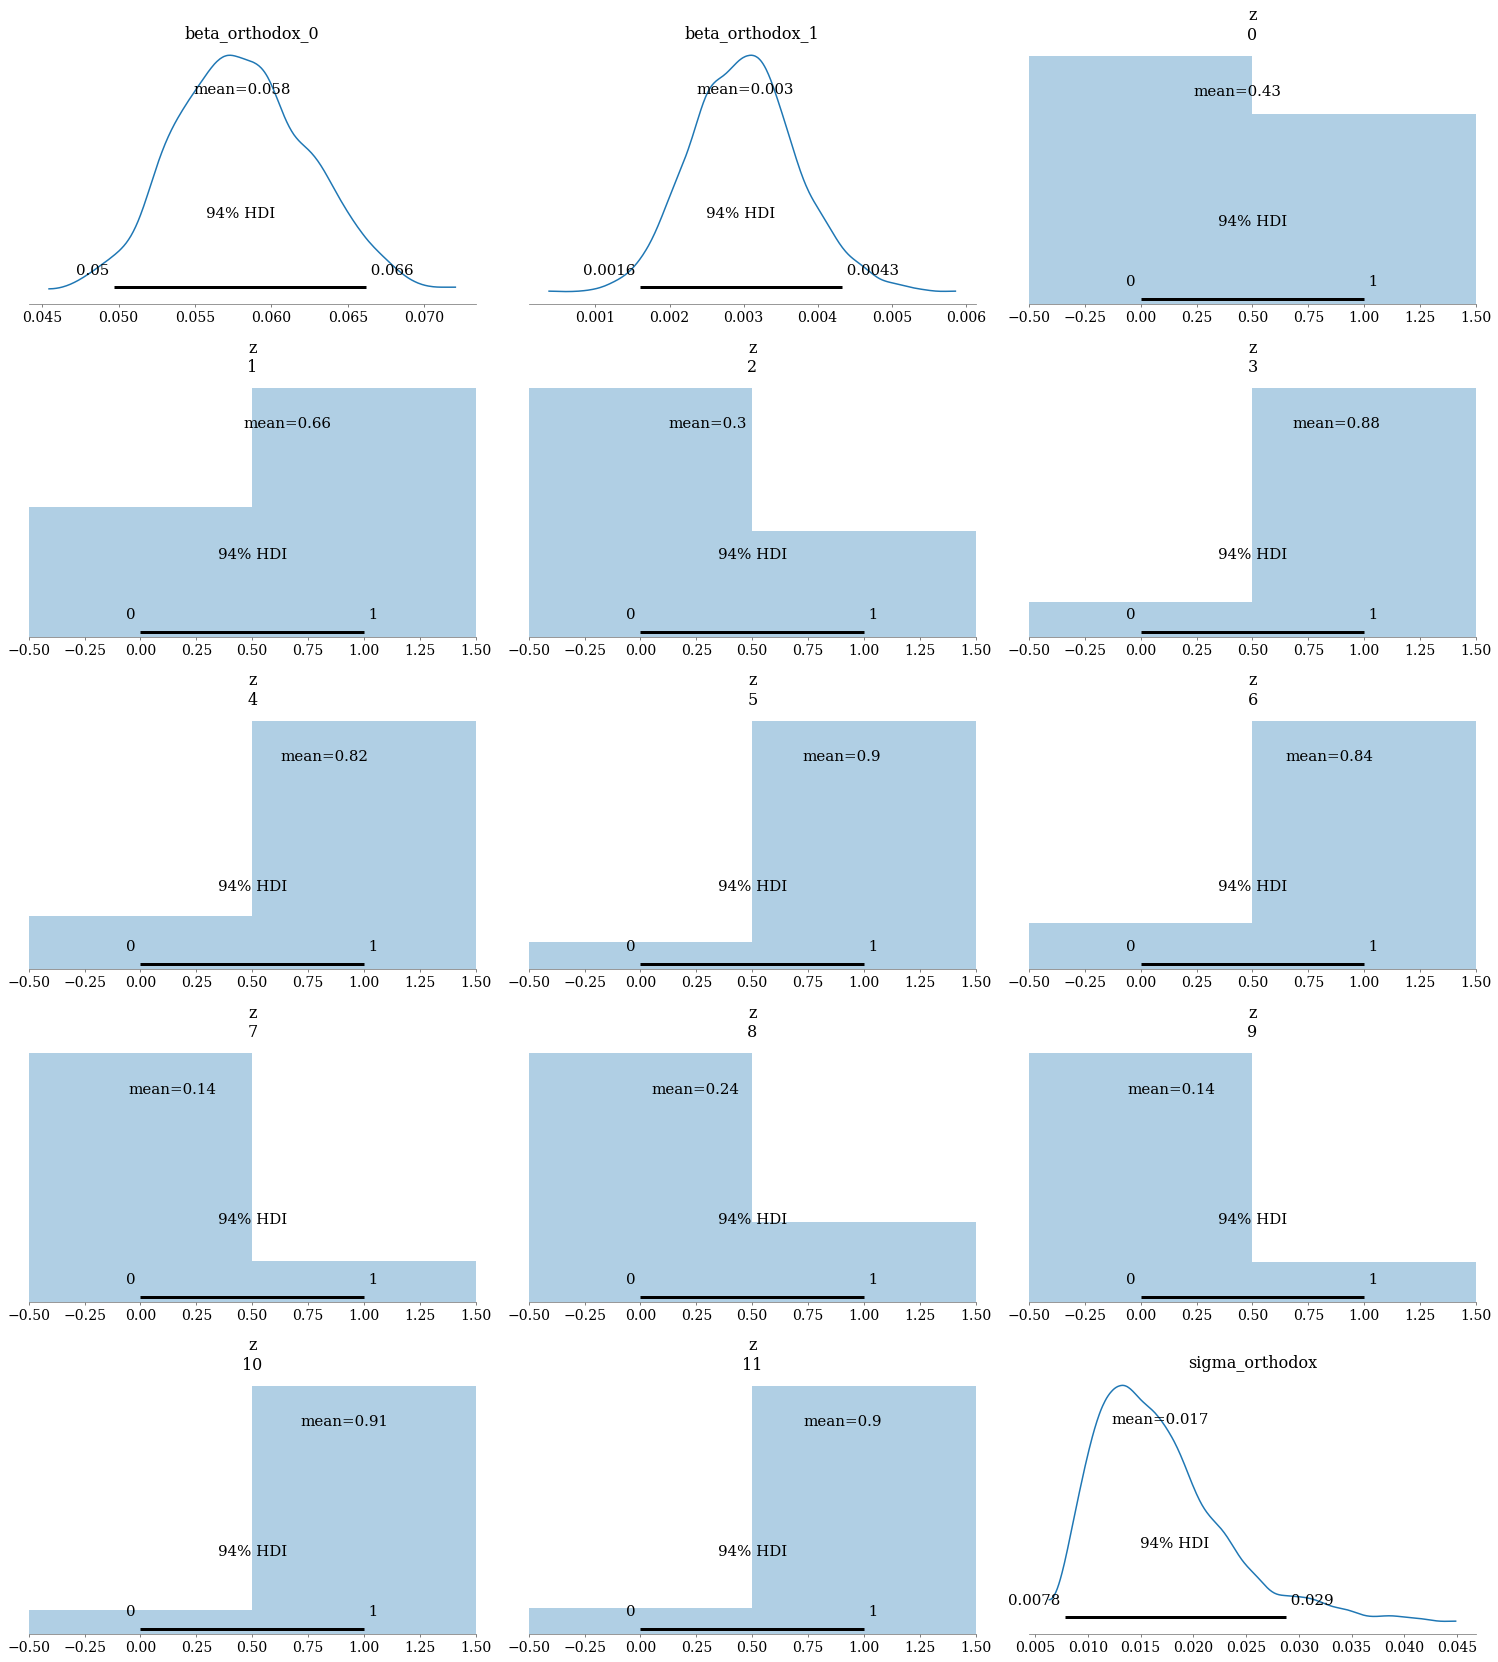

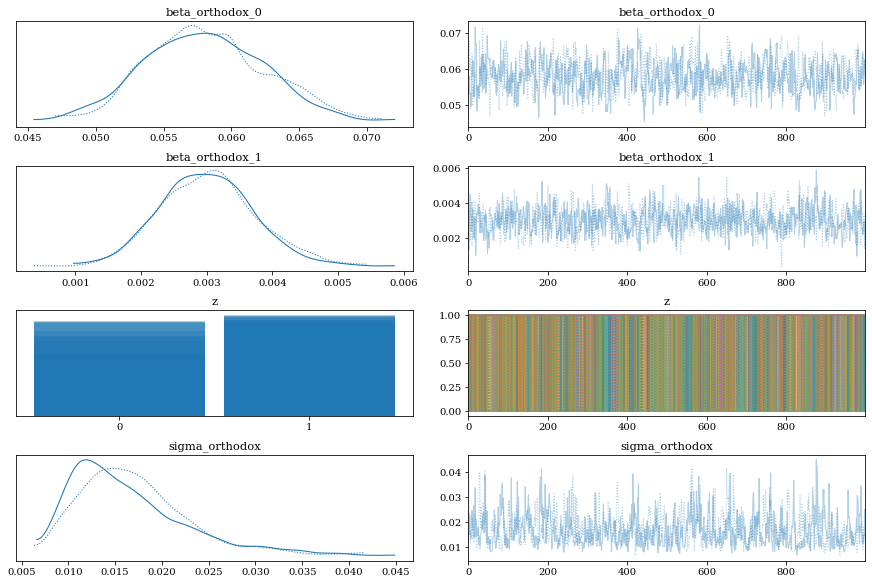

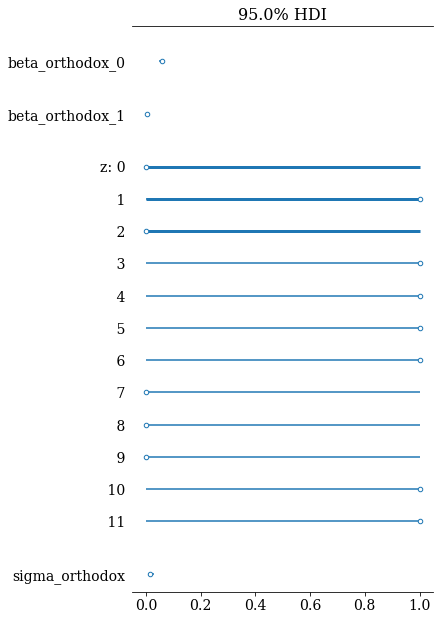

In [12]:
mu_beta_orthodox_0 = 0.21 * 0.3
mu_beta_orthodox_1 = 0.004

with pm.Model() as model_orthodox:
    beta_orthodox_0 = pm.Normal(
        "beta_orthodox_0",
        mu=mu_beta_orthodox_0,
        sigma=0.005,
    )
    beta_orthodox_1 = pm.Normal(
        "beta_orthodox_1",
        mu=mu_beta_orthodox_1,
        sigma=0.001,
    )
    theta = 0.5
    z = pm.Bernoulli('z', p=theta, shape=n)
    sigma_total = pm.Exponential('sigma_orthodox', 10)
    missing = np.asarray(data_pm.orthodox_in_russia) * z
    mu_total = beta_orthodox_0 + beta_orthodox_1 * t - missing
    total = pm.Normal(
        'register',
        mu=mu_total,
        sigma=sigma_total,
        observed=data_pm.register_orthodox,
    )

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.95)

After converted to real population and percentages, the growth rates of the orthodox parish and orthodox population within the
city are, respectively 2.3 per cent and 5.1 per cent per annum.

## Discussion and conclusion

The results indicate that
